# Detailed Implementation Plan
1. **Adapt Knowledge from Task 1**: Advanced Analysis

- Objective: Build on initial time series methods by applying both univariate and multivariate models to capture dependencies and potential regime changes.

- Approach: Implement models like `VAR` and `Markov-Switching ARIMA` to handle market condition changes and dependencies among economic variables.

2. **Collect Economic, Technological, and Political Data
Data Source**: Use `wbdata` to pull indicators such as GDP, inflation, and exchange rates for major economies.

Integration: Add the new data to the original dataset and use merge_economic_data() to prepare for multivariate analysis.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd '/content/drive/MyDrive/Classroom/KifiyaAIM/week 10/Brent-Oil-Price-Analysis-and-Change-Point-Detection/notebooks'

In [3]:
# from IPython.display import clear_output
# !pip install wbdata
# clear_output()


In [4]:
 # Import necessary libraries along with our custom functions from /src
import sys
import os

# Get the current directory of this notebook
current_dir = os.path.dirname(os.path.abspath("__file__"))

# Construct the absolute path to the src directory
src_dir = os.path.join(current_dir, '..', 'src')

# Add the src directory to the system path
sys.path.append(src_dir)

import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
from data_preprocessing import load_data, merge_economic_data
from economic_data import fetch_economic_data
from advanced_models import fit_var, evaluate_var_model, fit_markov_switching,\
    evaluate_markov_switching_model, fit_lstm, evaluate_lstm_model, plot_result
from sklearn.metrics import mean_squared_error, mean_absolute_error


2024-11-07 07:49:58.857161: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-07 07:49:58.996542: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-07 07:49:59.150145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730954999.362020   96636 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730954999.406337   96636 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 07:49:59.766252: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Data Collection and Preparation

**Load Brent Oil Prices**: Load the oil_data from your preprocessed dataset.

**Fetch Economic Data**: Use fetch_economic_data() to collect relevant economic indicators like GDP, inflation, and exchange rates from the World Bank API.

**Merge Data**: Use merge_economic_data() to integrate economic indicators with oil prices for multivariate modeling.

In [5]:
# Load and preprocess data
df = load_data('../data/BrentOilPrices.csv')

# Fetch additional economic indicators
indicators = {
    'NY.GDP.MKTP.CD': 'GDP (current US$)',
    'FP.CPI.TOTL': 'Inflation, consumer prices (annual %)',
    'SL.UEM.TOTL.ZS': 'Unemployment, total (% of total labor force)',
    'PA.NUS.FCRF': 'Official exchange rate (LCU per US$, period average)',
    'SL.TLF.TOTL.IN': 'Total labor force'
}
# countries = ['USA', 'SAU', 'RUS', 'CAN', 'CHN']
economic_data = fetch_economic_data(indicators, start_date='1987-01-01', end_date='2022-01-01')


/home/seyfe/Desktop/KAIM/Brent_Oil_Price_Analysis/notebooks/../src/data_preprocessing.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(filepath, parse_dates=['Date'], dayfirst=True)
/home/seyfe/Desktop/KAIM/Brent_Oil_Price_Analysis/notebooks/../src/economic_data.py:22: RuntimeWarning: invalid value encountered in scalar divide
  aggregated_unemployment = data.groupby('date').apply(lambda x: x['Weighted Unemployment'].sum() / x['Total labor force'].sum())


In [6]:
df.shape

(9011, 1)

In [7]:
df.head(10)

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
1987-05-27,18.60
1987-05-28,18.60
1987-05-29,18.58
1987-06-01,18.65


In [8]:
economic_data.head(10)

,date,Global GDP (current US$),Global Inflation Rate (%),Global Unemployment Rate (%)
0,1987,1.245455e+14,7.056892,NaN
1,1988,1.397580e+14,7.338715,NaN
2,1989,1.481443e+14,7.493588,NaN
3,1990,1.686607e+14,7.699216,NaN
4,1991,1.741233e+14,8.309250,4.875858
5,1992,1.857785e+14,8.685610,4.998222
6,1993,1.895073e+14,8.965132,5.254124
7,1994,2.041880e+14,9.281196,5.516652
8,1995,2.287504e+14,9.572927,5.701210
9,1996,2.360761e+14,9.621872,5.790255


In [9]:
# Rename date column
economic_data.rename(columns={'date': 'Date'}, inplace=True)

In [10]:
economic_data.shape

(36, 4)

In [11]:
economic_data = economic_data.sort_values('Date')  # Ensure data is sorted by date
economic_data.set_index('Date', inplace=True)

In [12]:
economic_data.tail(10)

,Global GDP (current US$),Global Inflation Rate (%),Global Unemployment Rate (%)
Date,,,
2013,6.354497e+14,13.391154,6.039311
2014,6.546738e+14,13.849517,5.932317
2015,6.159641e+14,13.895497,6.009809
2016,6.244461e+14,14.258420,6.001066
2017,6.684880e+14,14.598872,5.944567
2018,7.115345e+14,14.970177,5.807823
2019,7.224217e+14,15.460576,5.667802
2020,7.016825e+14,15.940220,6.578727
2021,8.046830e+14,17.353942,6.105657


Since the **Brent oil dataset** contains daily data (date and price), and the **economic data** is annual (one row per year), you’ll need to decide how to align the yearly data with daily data. A common approach is to `forward-fill` the yearly values to each day of that year in the daily dataset, so that each day within a given year gets the same yearly aggregated values.

In [13]:
# Step 1: Ensure both DataFrames have datetime index
df.index = pd.to_datetime(df.index)
economic_data.index = pd.to_datetime(economic_data.index, format='%Y')  # economic_data has only years

# Step 2: Create a yearly date range starting from 1987 to the last year in df
yearly_range = pd.date_range(start='1987', end=df.index.max(), freq='Y')

# Step 3: Reindex economic_data with the yearly range and forward-fill at the yearly level
economic_data = economic_data.reindex(yearly_range, method='ffill')

# Step 4: Expand economic_data to daily dates, forward-filling within each year
date_range = pd.date_range(df.index.min(), df.index.max(), freq='D')
economic_data_expanded = economic_data.reindex(date_range).fillna(method='ffill')

# Step 5: Merge the daily data with the expanded yearly data
merged_df = df.merge(economic_data_expanded, how='left', left_index=True, right_index=True)

In [14]:
merged_df.head()

,Price,Global GDP (current US$),Global Inflation Rate (%),Global Unemployment Rate (%)
Date,,,,
1987-05-20,18.63,NaN,NaN,NaN
1987-05-21,18.45,NaN,NaN,NaN
1987-05-22,18.55,NaN,NaN,NaN
1987-05-25,18.60,NaN,NaN,NaN
1987-05-26,18.63,NaN,NaN,NaN


In [15]:
merged_df.tail()

,Price,Global GDP (current US$),Global Inflation Rate (%),Global Unemployment Rate (%)
Date,,,,
2022-11-08,96.85,8.046830e+14,17.353942,6.105657
2022-11-09,93.05,8.046830e+14,17.353942,6.105657
2022-11-10,94.25,8.046830e+14,17.353942,6.105657
2022-11-11,96.37,8.046830e+14,17.353942,6.105657
2022-11-14,93.59,8.046830e+14,17.353942,6.105657


In [16]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9011 entries, 1987-05-20 to 2022-11-14
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Price                         9011 non-null   float64
 1   Global GDP (current US$)      8852 non-null   float64
 2   Global Inflation Rate (%)     8852 non-null   float64
 3   Global Unemployment Rate (%)  7830 non-null   float64
dtypes: float64(4)
memory usage: 352.0 KB


### Handling missing values

Since I forward-filled the annual economic data at first, I could continue with a backward fill (bfill) for any remaining NaNs.

In [17]:
merged_df.fillna(method='bfill', inplace=True)

In [18]:
merged_df.head()

,Price,Global GDP (current US$),Global Inflation Rate (%),Global Unemployment Rate (%)
Date,,,,
1987-05-20,18.63,1.245455e+14,7.056892,4.875858
1987-05-21,18.45,1.245455e+14,7.056892,4.875858
1987-05-22,18.55,1.245455e+14,7.056892,4.875858
1987-05-25,18.60,1.245455e+14,7.056892,4.875858
1987-05-26,18.63,1.245455e+14,7.056892,4.875858


In [19]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9011 entries, 1987-05-20 to 2022-11-14
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Price                         9011 non-null   float64
 1   Global GDP (current US$)      9011 non-null   float64
 2   Global Inflation Rate (%)     9011 non-null   float64
 3   Global Unemployment Rate (%)  9011 non-null   float64
dtypes: float64(4)
memory usage: 352.0 KB


### Exploratory Data Analysis (EDA)

**Visualize Trends and Correlations:**

Plot oil prices with additional indicators to understand correlations.

Use heatmaps or correlation matrices to examine relationships between variables.

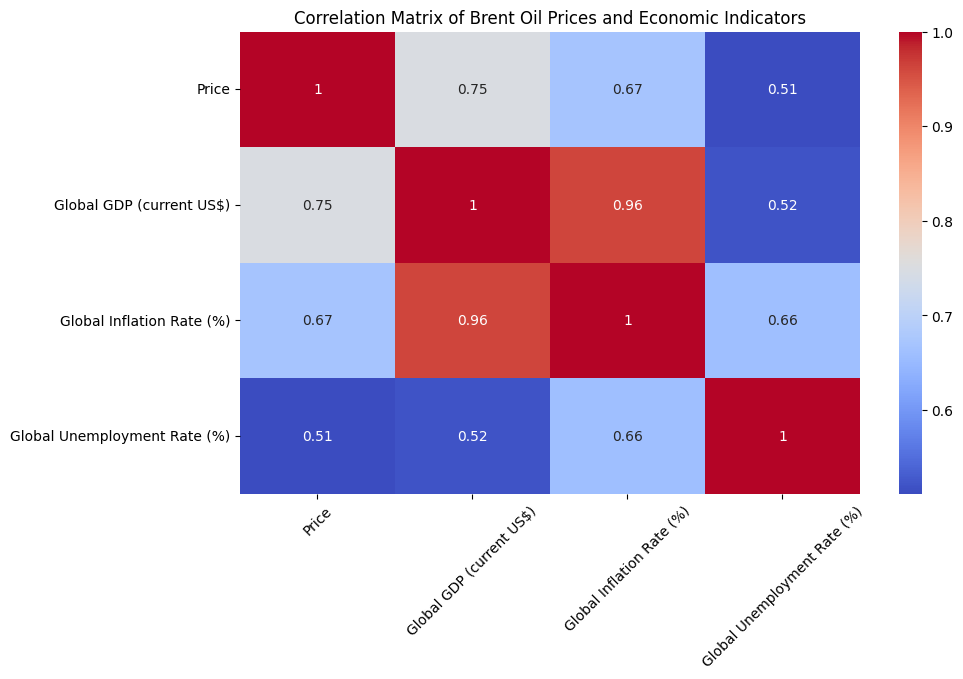

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(merged_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Brent Oil Prices and Economic Indicators")
plt.xticks(rotation=45)
plt.show()


### Advanced Time Series Modeling
**VAR (Vector Autoregression):** Use for multivariate time series analysis, capturing dependencies among oil prices and economic indicators.

**Markov-Switching ARIMA:** Apply for regime-switching analysis to capture different market conditions.

**LSTM (Long Short-Term Memory)**: Implement for complex, sequential dependencies, focusing on univariate time series.

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
merged_df_scaled = pd.DataFrame(scaler.fit_transform(merged_df), columns=merged_df.columns, index=merged_df.index)

In [22]:
from sklearn.decomposition import PCA

# Apply PCA and keep only the principal components that explain most variance
pca = PCA(n_components=2)  # Choose number of components based on explained variance
merged_df_pca = pca.fit_transform(merged_df)

merged_df_pca = pd.DataFrame(merged_df_pca, index=merged_df.index, columns=['PC1', 'PC2'])


In [23]:
# # Fit and evaluate VAR model
# var_model = fit_var(merged_df_pca)
# evaluate_var_model(var_model, merged_df_pca, steps=5)

/home/seyfe/Desktop/KAIM/Brent_Oil_Price_Analysis/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


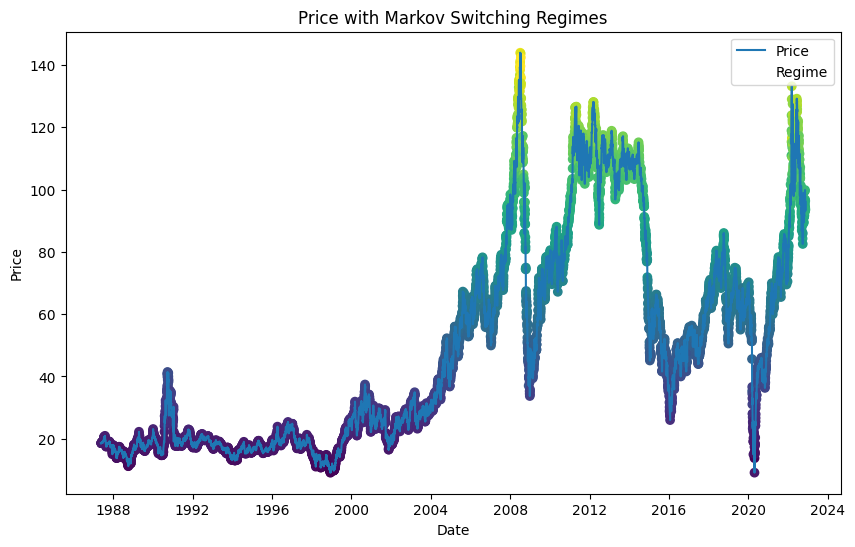

Markov Switching Model Evaluation Metrics:
Mean Absolute Error (MAE): 1.3599527502147533
Mean Squared Error (MSE): 4.503121981706792
Root Mean Squared Error (RMSE): 2.1220560741193415


In [24]:
# Fit and evaluate Markov Switching model
markov_model = fit_markov_switching(merged_df)
evaluate_markov_switching_model(markov_model, merged_df)

In [25]:
# LSTM Model
fit_lstm(merged_df)

2024-11-07 07:50:43.883591: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/seyfe/Desktop/KAIM/Brent_Oil_Price_Analysis/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step - loss: 0.0151
Epoch 2/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.0016
Epoch 3/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.0013
Epoch 4/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - loss: 0.0012
Epoch 5/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.0010
Epoch 6/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - loss: 0.0010
Epoch 7/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 40s 142ms/step - loss: 8.6782e-04
Epoch 8/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 39s 140ms/step - loss: 8.5136e-04
Epoch 9/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - loss: 7.2961e-04
Epoch 10/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 7.9609e-04
Epoch 11/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - loss: 7.0038e-04
Epoch 12/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 38s 89ms/step - loss: 6.2879e-04
Epoch 13/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - loss: 6.7276e-04
Epoch 14/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 23s 81ms/step - loss:

Model saved as ../dashboard/backend/models/lstm_model.h5 and scaler saved as ../dashboard/backend/models/scaler.pkl


### Model Evaluation
Compute RMSE, MAE, and R-Squared for each model to compare their performance.

Split data into training and test sets for cross-validation.

In [26]:
# Prepare test data and use the saved model and scaler for predictions
from tensorflow.keras.models import load_model
import pickle
import numpy as np

look_back = 60  # The default Number of previous time steps to use as input

# Load the saved model and scaler
scaler_path = '../dashboard/backend/models/scaler.pkl'
lstm_h5_path = '../dashboard/backend/models/lstm_model.h5'

model = load_model(lstm_h5_path)
with open(scaler_path, 'rb') as scaler_file:
    scaler = pickle.load(scaler_file)

# Scale the test data
test_data = scaler.transform(merged_df['Price'].values.reshape(-1, 1))
X_test, y_test = [], []
for i in range(look_back, len(test_data)):
    X_test.append(test_data[i - look_back:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Make predictions and inverse transform to the original scale
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
evaluate_lstm_model(y_test, y_pred)

280/280 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step
Mean Absolute Error (MAE): 1.1157288387870936
Mean Squared Error (MSE): 2.687919389955937
Root Mean Squared Error (RMSE): 1.639487538823012
R-Squared (R2 Score): 0.9975139382751713
Mean Absolute Percentage Error (MAPE): 2.7081777504675433 %


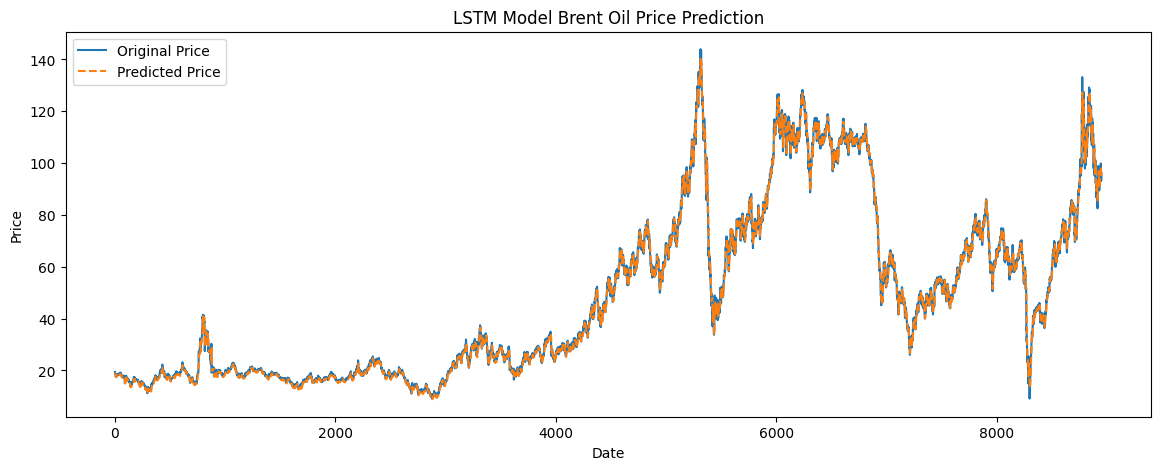

In [27]:

# Plot the results
plot_result(y_test, y_pred)